# Setup a reinforcement learning problem for a virtual particle image velocimetry (PIV) setup

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards
from pykitPIV.flowfield import compute_q_criterion
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import torch
import sys, os
import time

2025-02-15 22:57:33.616311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Prepare specifications for pykitPIV parameters:

In [2]:
particle_spec = {'diameters': (1, 1),
                 'distances': (2, 2),
                 'densities': (0.4, 0.4),
                 'diameter_std': 1,
                 'seeding_mode': 'random'}

flowfield_spec = {'flowfield_size': (200, 500),
                  'flowfield_type': 'random smooth',
                  'gaussian_filters': (10, 10),
                  'n_gaussian_filter_iter': 10,
                  'displacement': (2, 2),
                  # 'apply_SLM': True,
                  # 'integral_time_scale': 1,
                  # 'sigma': 1,
                  # 'n_stochastic_particles': 1000000,
                  # 'n_iterations': 100
                 }

motion_spec = {'n_steps': 10,
               'time_separation': 1,
               'particle_loss': (0, 0),
               'particle_gain': (0, 0)}

image_spec = {'exposures': (0.98, 0.98),
              'maximum_intensity': 2**16-1,
              'laser_beam_thickness': 1,
              'laser_over_exposure': 1,
              'laser_beam_shape': 0.95,
              'alpha': 1/8,
              'clip_intensities': True,
              'normalize_intensities': False}

Use LIMA as an inference model:

In [3]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [4]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [5]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


***

## Create the RL environment

Initialize the `Gymnasium` environment:

In [6]:
env = PIVEnv(interrogation_window_size=(100,100),
             interrogation_window_size_buffer=10,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=lima_inference_model,
             random_seed=None)

Reset the environment:

In [7]:
camera_position, prediction_tensor, targets_tensor = env.reset()

In [8]:
camera_position

array([ 38, 185])

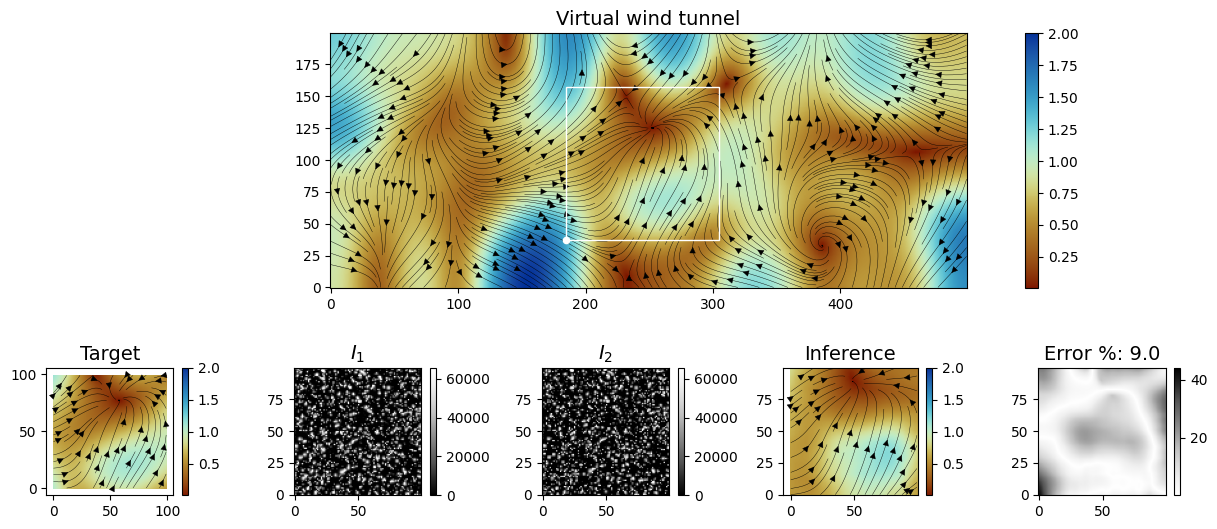

In [9]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename='ml_PIVEnv_render.png')

In [10]:
q_criterion = compute_q_criterion(env.flowfield.velocity_field)

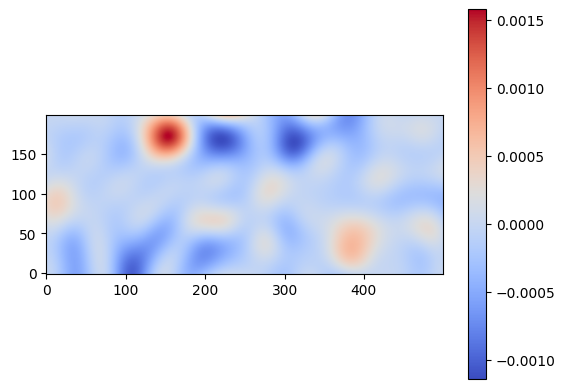

In [11]:
plt.imshow(q_criterion[0,:,:], origin='lower', cmap='coolwarm')
plt.colorbar()

Test making 10 random steps in the environment:

In [12]:
# for _ in range(0,10):

#     print(np.random.choice(5))

In [13]:
# for _ in range(0,20):

#     action = np.random.choice(5)

#     print(action)
    
#     camera_position, reward, terminated, truncated = env.step(action, 
#                                                               verbose=True)

In [14]:
# plt = env.render(camera_position,
#                  c='white',
#                  s=20,
#                  lw=1,
#                  normalize_cbars=True,
#                  cmap=cmc.roma,
#                  add_streamplot=True,
#                  streamplot_density=3,
#                  streamplot_color='k',
#                  streamplot_linewidth=0.3,
#                  figsize=(15,6), 
#                  filename='ml_PIVEnv_render.png')

Reset the environment with a user-defined initial camera position:

In [15]:
# camera_position, prediction_tensor, targets_tensor = env.reset(imposed_camera_position=np.array([0, 50]))

# plt = env.render(camera_position,
#                  c='white',
#                  s=20,
#                  lw=1,
#                  normalize_cbars=True,
#                  cmap=cmc.roma,
#                  add_streamplot=True,
#                  streamplot_density=3,
#                  streamplot_color='k',
#                  streamplot_linewidth=0.3,
#                  figsize=(15,6), 
#                  filename='ml_PIVEnv_render.png')

***

## Create and train an RL agent

In [16]:
n_episodes = 5
n_iterations = 4
random_seed = 0
verbose = False
iter_count = 0
epsilon = 0.5
batch_size = 10
initial_learning_rate = 0.01
alpha_lr = 0.0001
n_epochs = 10
n_decay_steps = int(n_episodes/1.5)

Define the Q-network:

In [17]:
class QNetwork(tf.keras.Model):
    
    def __init__(self, n_actions):
        
        super(QNetwork, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.dense2 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='linear', kernel_initializer=tf.keras.initializers.Ones)

    def call(self, state):
        
        x = self.dense1(state)
        x = self.dense2(x)
        
        return self.output_layer(x)

Initialize the camera agent:

In [18]:
ca = CameraAgent(env=env,
                 target_q_network=QNetwork(env.n_actions),
                 selected_q_network=QNetwork(env.n_actions),
                 memory_size=1000,
                 batch_size=batch_size,
                 n_epochs=10,
                 learning_rate=0.001,
                 optimizer='RMSprop',
                 discount_factor=0.95)

The uploaded environment has 5 actions.


Define the cosine learning rate decay:

In [19]:
def decayed_learning_rate(step, initial_learning_rate, alpha, n_epochs, decay_steps):
    
    step = np.min([step, decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    
    return initial_learning_rate * decayed

Initialize an object of the `Rewards` class to use one of the custom-built reward functions:

In [20]:
rewards = Rewards(verbose=True)
reward_function = rewards.q_criterion

Define a transformation function for the reward which is appropriate to detecting vortex structures:

In [22]:
def reward_transformation(Q):
    Q = np.max(Q.clip(min=0))
    return Q

In [23]:
camera_position, prediction_tensor, targets_tensor = env.reset()

In [24]:
total_tic = time.perf_counter()

print('- '*50)

tic = time.perf_counter()

for episode in range(0,n_episodes):

    state = env.reset()
    total_reward = 0
    
    # Exploration probability decreases with training time:
    # epsilon = epsilon_start/np.exp(iter_count/(500))

    for _ in range(0,n_iterations):

        action = ca.choose_action(camera_position, epsilon=epsilon)
        print(action)
        
        next_camera_position, reward = env.step(action,
                                                reward_function=reward_function,
                                                reward_transformation=reward_transformation)
        
        ca.remember(camera_position, action, reward, next_camera_position)
        camera_position = next_camera_position
        total_reward += reward

    iter_count += 1
    
    # Train the Q-network, (but holds off with training until batch_size of samples is collected):
    if len(ca.memory.buffer) >= batch_size:
    
        current_lr = decayed_learning_rate(iter_count, initial_learning_rate, alpha_lr, n_epochs, n_decay_steps)
        ca.train(current_lr)
    
        if (episode+1) % 1 == 0 :
            ca.update_target_network()

    if (episode+1) % 100 == 0:
        toc = time.perf_counter()
        print(current_lr)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward:0.1f}")
        print(f'These episodes took: {(toc - tic):0.1f} sec.')
        print('- '*50)
        tic = time.perf_counter()

total_toc = time.perf_counter()
print(f'Total time: {(total_toc - total_tic)/60/60:0.2f} h.\n')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
0
0.0012148322
4
0.0022804427
0
0.0024778997
1
0.001743264
1
0.0004115618
3
0.0004218154
0
0.0022526328
2
0.00016852448
1
0.00053163024
0
0.00043214008
0
0.0003321833
1
0.00053173647
4
0.00063131424
4
0.00042069127
4
0.0010280791
4
0.00040902954
4
0.00021056752
4
0.0004419156
2
0.00046552168
4
0.00048269768
Total time: 0.01 h.



Text(0, 0.5, 'MSE loss')

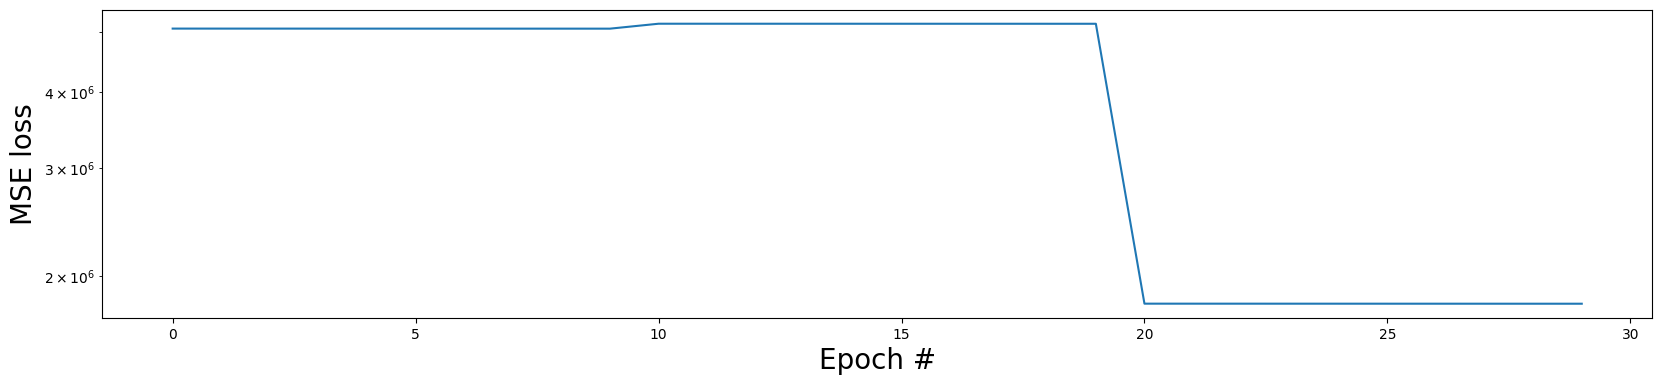

In [25]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()

plt.figure(figsize=(20,4))
plt.semilogy(MSE_losses_collected)
# plt.ylim([0.00001,10])
plt.xlabel('Epoch #', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)

In [ ]:
image_obj = env.record_particles(camera_position)

In [ ]:
plt.imshow(image_obj.images_I1[0,0,:,:], cmap='Greys_r', origin='lower')

In [ ]:
plt.imshow(image_obj.images_I2[0,0,:,:], cmap='Greys_r', origin='lower')

In [ ]:
image_obj.plot_field_magnitude(0, 
                               add_streamplot=True,
                               streamplot_density=1,
                               streamplot_color='k',)

In [ ]:
image_obj.animate_image_pair(0, filename='image.gif')

***